In [1]:
!python export.py --weights yolov5s.pt --include engine --nms --conf-thres 0.35 --iou-thres 0.45 --topk-all 100 --workspace 8 --device 0

export: data=data/coco128.yaml, weights=['yolov5s.pt'], imgsz=[640, 640], batch_size=1, device=0, half=False, inplace=False, train=False, optimize=False, int8=False, dynamic=False, simplify=False, opset=12, verbose=False, workspace=8, nms=True, agnostic_nms=False, topk_per_class=100, topk_all=100, iou_thres=0.45, conf_thres=0.35, include=['engine']
YOLOv5 🚀 v6.1-179-g40f46cb torch 1.11.0+cu115 CUDA:0 (NVIDIA GeForce RTX 3070 Laptop GPU, 7982MiB)

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients

PyTorch: starting from yolov5s.pt with output shape (1, 25200, 85) (14.1 MB)

ONNX: starting export with onnx 1.11.0...
ONNX: export success, saved as yolov5s.onnx (28.0 MB)

ONNX: starting export with onnx 1.11.0...
ONNX: export success, saved as yolov5s.onnx (28.0 MB)

TensorRT: EfficientNMS plugin only supprot TensorRT greater than 8.0.0 ...

TensorRT: starting export with TensorRT 8.2.3.0...
[05/09/2022-16:35:32] [TRT] [I] [MemUsageChange] Init CUDA: CPU +448, 

In [2]:
import cv2
import torch
import numpy as np
import random
import tensorrt as trt
from collections import OrderedDict,namedtuple
from PIL import Image

In [3]:
w = "yolov5s.engine"
device = torch.device("cuda:0")

In [4]:
Binding = namedtuple('Binding', ('name', 'dtype', 'shape', 'data', 'ptr'))
logger = trt.Logger(trt.Logger.INFO)
trt.init_libnvinfer_plugins(logger, namespace="")
with open(w, 'rb') as f, trt.Runtime(logger) as runtime:
    model = runtime.deserialize_cuda_engine(f.read())
bindings = OrderedDict()
fp16 = False  # default updated below
for index in range(model.num_bindings):
    name = model.get_binding_name(index)
    dtype = trt.nptype(model.get_binding_dtype(index))
    shape = tuple(model.get_binding_shape(index))
    data = torch.from_numpy(np.empty(shape, dtype=np.dtype(dtype))).to(device)
    bindings[name] = Binding(name, dtype, shape, data, int(data.data_ptr()))
    if model.binding_is_input(index) and dtype == np.float16:
        fp16 = True
binding_addrs = OrderedDict((n, d.ptr) for n, d in bindings.items())
context = model.create_execution_context()

[05/09/2022-16:37:14] [TRT] [I] [MemUsageChange] Init CUDA: CPU +458, GPU +0, now: CPU 525, GPU 1242 (MiB)
[05/09/2022-16:37:14] [TRT] [I] Loaded engine size: 31 MiB
[05/09/2022-16:37:15] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +790, GPU +340, now: CPU 1357, GPU 1605 (MiB)
[05/09/2022-16:37:15] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +196, GPU +342, now: CPU 1553, GPU 1947 (MiB)
[05/09/2022-16:37:15] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in engine deserialization: CPU +0, GPU +29, now: CPU 0, GPU 29 (MiB)
[05/09/2022-16:37:16] [TRT] [I] [MemUsageChange] Init cuBLAS/cuBLASLt: CPU +0, GPU +10, now: CPU 3167, GPU 2837 (MiB)
[05/09/2022-16:37:16] [TRT] [I] [MemUsageChange] Init cuDNN: CPU +0, GPU +8, now: CPU 3167, GPU 2845 (MiB)
[05/09/2022-16:37:16] [TRT] [I] [MemUsageChange] TensorRT-managed allocation in IExecutionContext creation: CPU +0, GPU +88, now: CPU 0, GPU 117 (MiB)


In [5]:
from utils.augmentations import letterbox

In [6]:
names = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 
         'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 
         'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 
         'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 
         'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 
         'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'couch', 
         'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 
         'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 
         'hair drier', 'toothbrush']
colors = {name:[random.randint(0, 255) for _ in range(3)] for i,name in enumerate(names)}

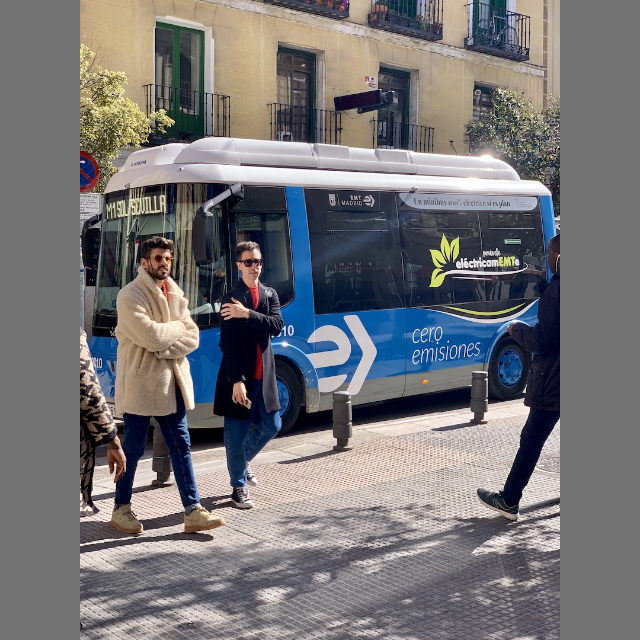

In [7]:
image = cv2.imread("data/images/bus.jpg")
image,ratio,dwdh = letterbox(image,auto=False)
image = cv2.cvtColor(image,cv2.COLOR_BGR2RGB)
Image.fromarray(image)

In [8]:
img = image.copy()
img = img.transpose((2, 0, 1))
img = np.expand_dims(img,0)
img = np.ascontiguousarray(img)

In [9]:
im = torch.from_numpy(img).to(device)
im = im.float() if not fp16 else im.half()
im/=255
im.shape

torch.Size([1, 3, 640, 640])

In [10]:
binding_addrs['images'] = int(im.data_ptr())
context.execute_v2(list(binding_addrs.values()))

True

In [11]:
nums = bindings['num_detections'].data.squeeze()
boxes = bindings['detection_boxes'].data[:,:nums].squeeze()
scores = bindings['detection_scores'].data[:,:nums].squeeze()
classes = bindings['detection_classes'].data[:,:nums].squeeze()

In [12]:
for i in range(nums):
    bbox = boxes[i].round().int()
    print(bbox)
    score = scores[i]
    clss = classes[i]
    name = names[clss]
    color = colors[name]
    cv2.rectangle(image,bbox[:2].tolist(),bbox[2:].tolist(),color,2)
    cv2.putText(image,name,(int(bbox[0]), int(bbox[1]) - 2),cv2.FONT_HERSHEY_SIMPLEX,0.75,[225, 255, 255],thickness=2)

tensor([211, 241, 285, 518], device='cuda:0', dtype=torch.int32)
tensor([473, 229, 560, 522], device='cuda:0', dtype=torch.int32)
tensor([114, 235, 207, 544], device='cuda:0', dtype=torch.int32)
tensor([ 89, 132, 553, 465], device='cuda:0', dtype=torch.int32)
tensor([ 79, 328, 123, 518], device='cuda:0', dtype=torch.int32)


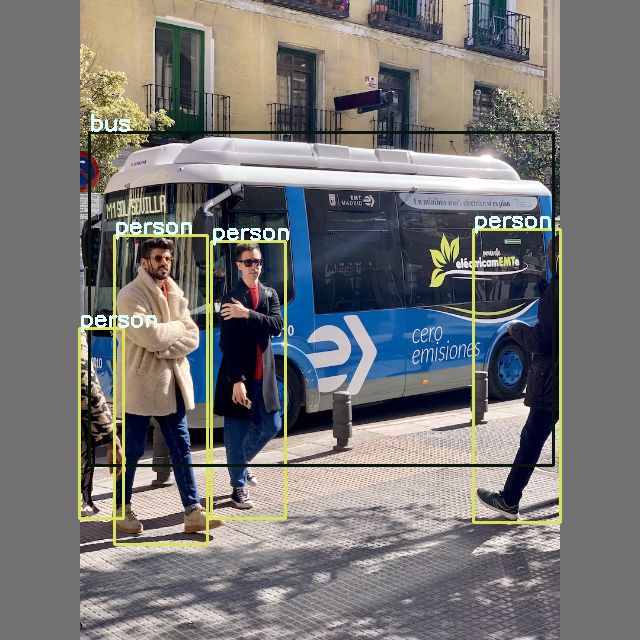

In [13]:
Image.fromarray(image)